## Aggregation File 

In this notebook we aggregate the key components of the analysis that we are interested in. They are not meant to be running consecutively, but rather to be used as a reference for the overall analysis that takes place. 

Here is a list of data sources used (or planned to be used) in this notebook:
- For Country shape files  [1](https://gadm.org/index.html)
-  For global population data [2](https://ghsl.jrc.ec.europa.eu/download.php?ds=pop)
- For spatially harmonized critical infrastructure data visit [3](https://zenodo.org/records/4957647)
- For gridded spatial deprivation index visit [4](https://sedac.ciesin.columbia.edu/data/set/povmap-grdi-v1)<br>
- For urban aglomoration data visit [7](https://africapolis.org/en)
========================================================================
- For access to harmonized NTL visit [5](https://figshare.com/articles/dataset/Harmonization_of_DMSP_and_VIIRS_nighttime_light_data_from_1992-2018_at_the_global_scale/9828827/2?file=17626016)
- For access to global 1x1km GDP estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)
- For access to global 1x1km electricity Consumption estimates visit [6](https://figshare.com/articles/dataset/Global_1_km_1_km_gridded_revised_real_gross_domestic_product_and_electricity_consumption_during_1992-2019_based_on_calibrated_nighttime_light_data/17004523/1?file=31456837)


Sources [3] and [4] are currently not included in the analysis. However they should be added similar to the population data as single datapoint for each grid cell through averaging/summing.
Similarly, sources [5] and electricity consumption of [6] should be added similar to the generated time series data for each cell of gdp.<br>




Before running make sure to activate the environment via the following command:<br>
<br>
REMARK: *(On my local machine i was not able to resolve a dependency issue with fiona in the virtual environment)*<br>

source myenv/bin/activate




In [1]:
# Import relevant packages
import numpy as np
import pandas as pd
import random
import PIL
import rasterio
import shapefile
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from pyproj import Transformer
from rasterio import features
from rasterio.enums import Resampling
from rasterio.mask import mask, raster_geometry_mask
from rasterio.plot import show
from shapely.geometry import Polygon, MultiPolygon, mapping
from skimage.measure import block_reduce
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm
from bridson import poisson_disc_samples
import matplotlib.patches as patches
import scienceplots 
import os 
import Tesselation as tess
import inference as infce
import ipykernel

os.environ['JAVA_HOME'] = '/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home'
os.environ['PATH'] = os.environ['JAVA_HOME'] + '/bin:' + os.environ['PATH']

print(os.environ['JAVA_HOME'])
print(os.environ['PATH'])

/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home
/opt/homebrew/opt/openjdk/libexec/openjdk.jdk/Contents/Home/bin:/opt/homebrew/bin:/Users/mengeshi/Library/Python/3.11/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin:/opt/homebrew/bin:/opt/homebrew/sbin:/Library/Frameworks/Python.framework/Versions/3.10/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/TeX/texbin


After importing the necessary libraries, we take a look at the tif files for NTL at different locations. 


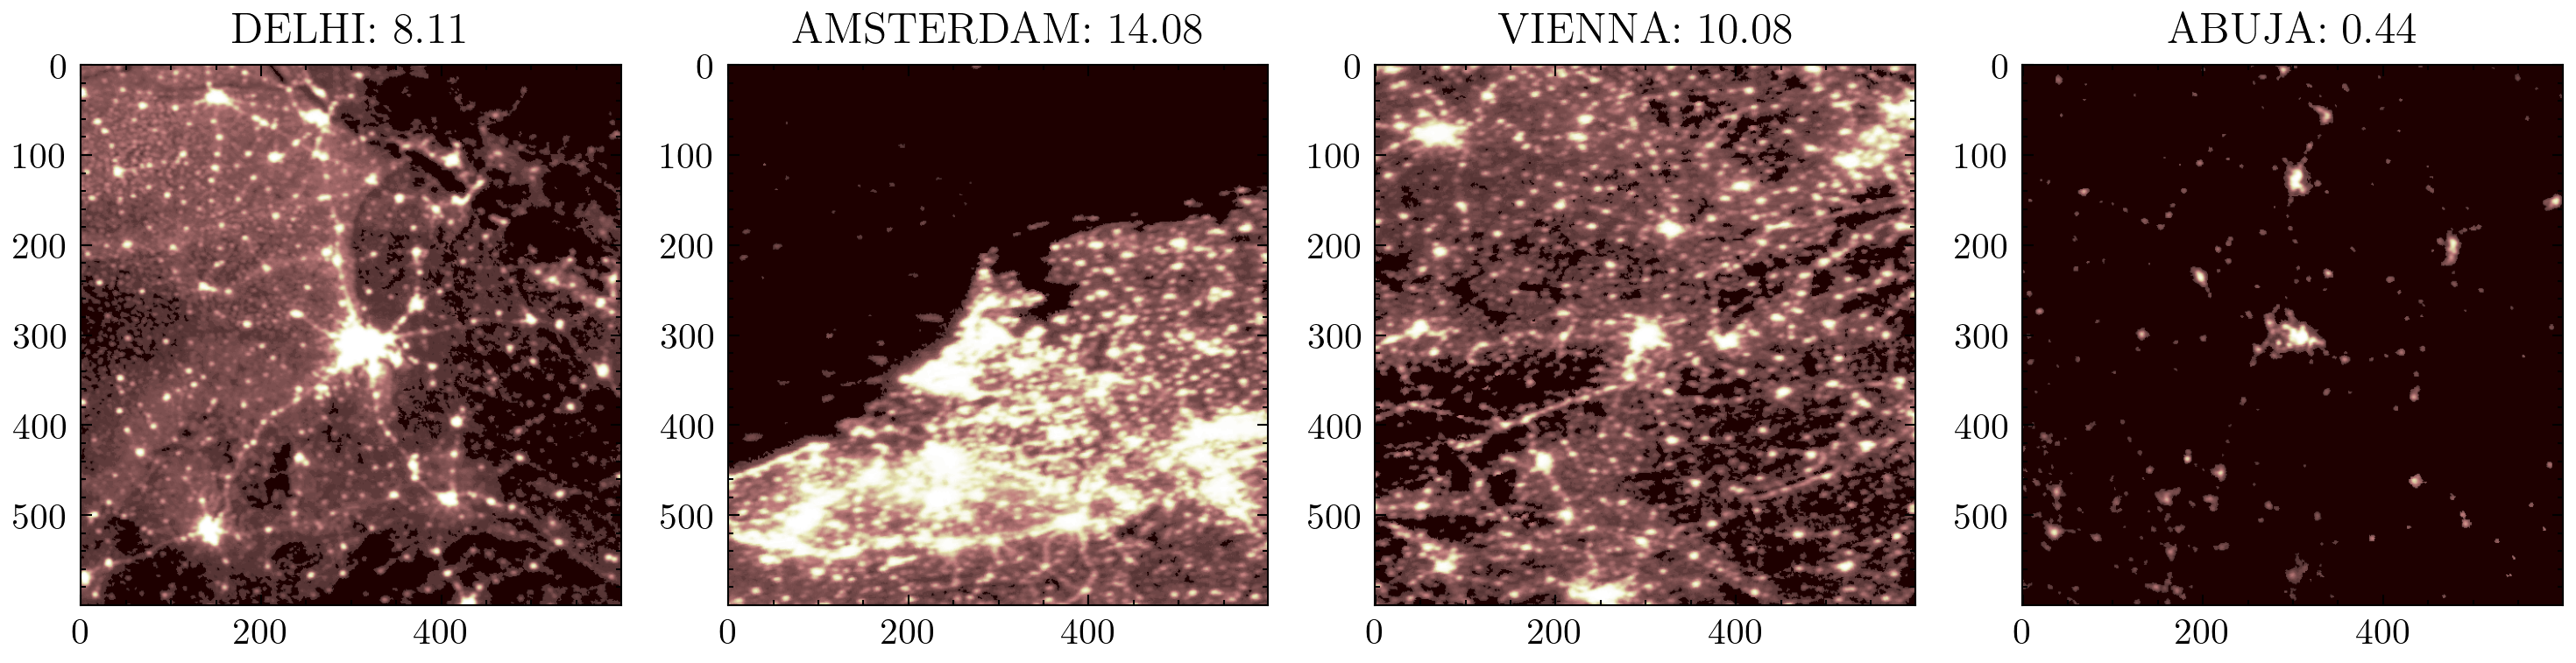

In [6]:
import importlib
importlib.reload(tess)
location_list = [
    ("Delhi", (28.7041, 77.1025)),
    ("Amsterdam", (52.3676, 4.9041)),
    ("Vienna", (48.2081, 16.3713)),
    ("Abuja", (9.0765, 7.3986))
]
#use science plots ieee style
plt.style.use('science')
raster_file_path = '../Data_summary/NTL/Harmonized_DN_NTL_2008_calDMSP.tif'
tess.plot_geographic_snapshots(location_list, raster_file_path, buffer_pixels=300)
#this can be similarly extended to other datasets as well!


Next we determine the region of interest. Generally we are interested in the entire world, but for demonstration purposes we choose Belgium, the Netherlands and Germany. 


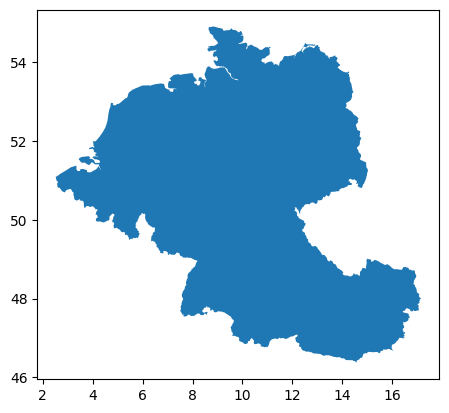

In [2]:
#%%time
#Country code can be found in the folder "Data_summary/country_geometry" in the file "Country_codes.csv"
country_codes = ["NL1", "BEL", "DEU", "AUT"]
#In the same folder we have the shapefiles for the countries as well
#Here we create a joint shape file out of the country list.

#read countries
combined_geo_df = tess.get_combined_country_geometry(country_codes)

# #read continent instead
# combined_geo_df = tess.get_continent_geometry("Africa", "../Data_summary/country_geometry/World_Continents.geojson")

tess.visualize_geometry(combined_geo_df) 

#Save the population density of the combined countries
tess.get_pop_density_for_geodf(combined_geo_df)




In [3]:
#%%time
#Use Population density of selected region to sample points 
raster_path = '../Data_summary/POP/selection.tif'
probability_gdf = tess.raster_to_spatial_probability_distribution(raster_path, power=2)


/opt/homebrew/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


25


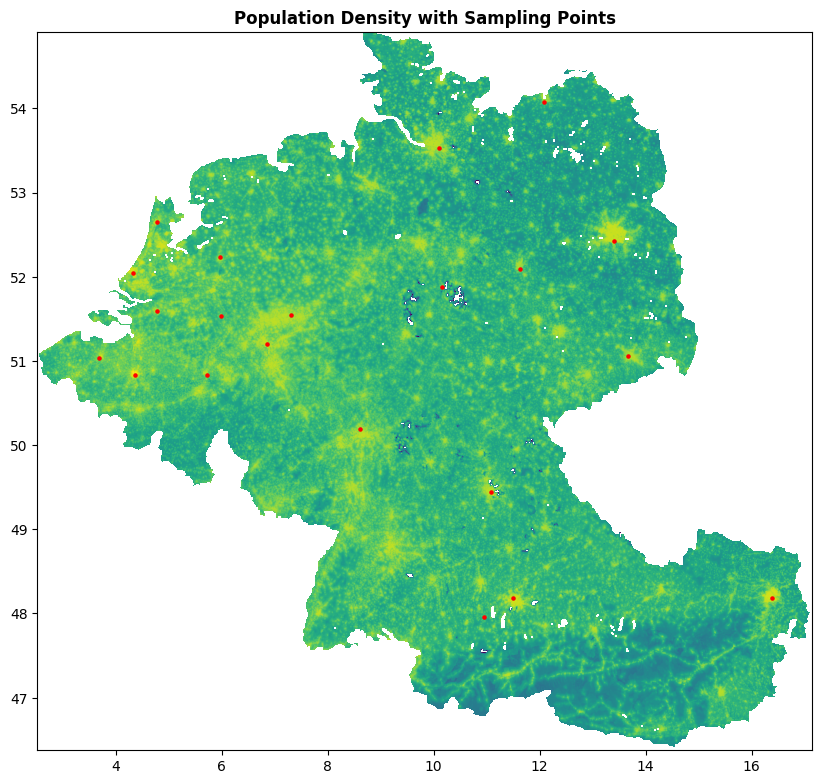

In [4]:
#%%time
import importlib
importlib.reload(tess)
points = tess.poisson_disk_sampling_with_geodf(probability_gdf, radius=0.5, n_samples=30)
#add bounds to avoid infinity polygons
boundary_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy([180.0,-180,180,-180] ,[90.0, 90,-90,-90]))


#add point1 to geodataframe points
points = pd.concat([boundary_points, points], ignore_index=True)

print(len(points))
# Visualize points excluding boundary points
tess.visualize_with_population(points[4:], raster_path)


**Next we create tesselation for a given sample points of region using voronoi tessellation.**
#### Alternative gridding approaches still needed
- *uniform grid*
- *hierarchical grid*


21


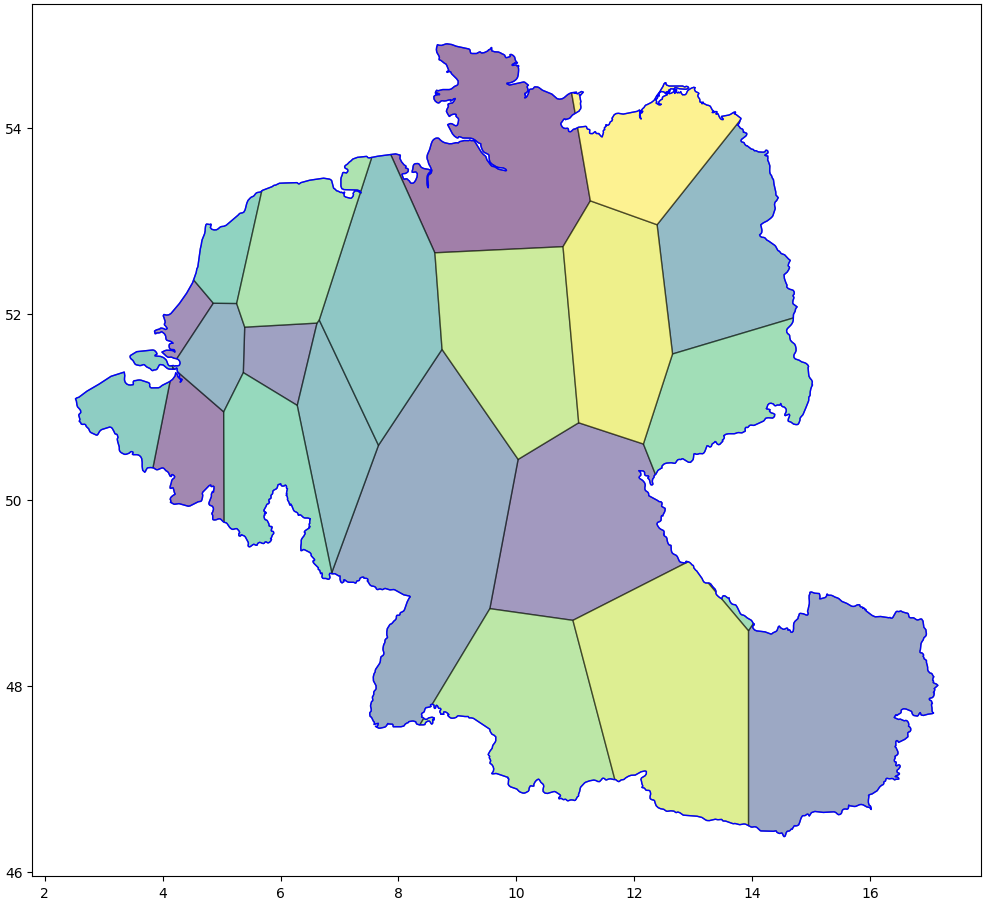

In [5]:
#%%time
#reload tess module
importlib.reload(tess)

boundary =   combined_geo_df.geometry[0]
voronoi_gdf = tess.create_voronoi_gdf(points, boundary)

print(len(voronoi_gdf))

#visulaize voronoi cells
tess.visualize_voronoi(voronoi_gdf, boundary)
#TODO check and exclude outside voronoi cells 



## Attributing Values to the Grids

Starting with Population we start creating time-series data with the available datasets. <br>
<br>
**Annually:**    GDP, Electricity Consumption <br>
**Once:**    Population, Deprivation Index, Aggricultural GDP, harmonized critical infrastructure.<br>

In [6]:
#%%time
#result_of_timing = %time -o 
# Attribute values that have only one measurement over time

population_gdf = tess.raster_to_population_gdf(raster_path)
#TODO more datasets to be included here!
attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(voronoi_gdf, population_gdf, 'population')
print("population done")
# Attribute values that have multiple mesuarements over time
# List of years to process
years = list(range(1993, 2020))
overalltime = 0
# Loop over each year to process GDP data
for year in years:

    raster_path = f'../Data_summary/GDP/{year}/{year}GDP.tif'
    output_raster_path = f'../Data_summary/POP/gdp_selection_{year}.tif'
    tess.selection_of_tif_for_geodf(combined_geo_df, raster_path, output_raster_path)
    #readtime = _ #save temproary variable 
    gdp_gdf = tess.raster_to_gdf(output_raster_path, name=f'gdp_{year}')
    gdp_value_name = f'gdp_{year}'  # Dynamic column name for the GDP data
    #print(readtime)
    attributed_voronoi_gdf = tess.attribute_values_to_voronoi_cells(attributed_voronoi_gdf, gdp_gdf, gdp_value_name)
    #overalltime += readtime

#print(overalltime)



Index(['geometry', 'index_right', 'population'], dtype='object')
population done
Index(['geometry', 'population', 'index_right', 'gdp_1993'], dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'index_right', 'gdp_1994'], dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'index_right',
       'gdp_1995'],
      dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'gdp_1995',
       'index_right', 'gdp_1996'],
      dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'gdp_1995',
       'gdp_1996', 'index_right', 'gdp_1997'],
      dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'gdp_1995',
       'gdp_1996', 'gdp_1997', 'index_right', 'gdp_1998'],
      dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'gdp_1995',
       'gdp_1996', 'gdp_1997', 'gdp_1998', 'index_right', 'gdp_1999'],
      dtype='object')
Index(['geometry', 'population', 'gdp_1993', 'gdp_1994', 'gdp_1

In [7]:
#save results in geodatatframe:
# They output file is located in the folder "Data_summary/Tessellation" in geojson format
tess.save_tessellation_data(points.iloc[4:], attributed_voronoi_gdf)

#NOTE: The way the data is saved should include information about the parameters used to generate the data.
#NOTE: The goal is time series data for each tesselation cell of the data of interest source [5] and [6]


## Open Tasks:

- Implement two more gridding techniques
- Establish pipline for: 
    - for each gridding technique
        - for each sampling density
            - save multiple griddings with corresponding time-series data
- Parallelize the process
- download the data from the sources
- solve issue with border gridd cells by adding additional vertices



# Subsequent analysis of data

## (1) compute correlation matrix

In [8]:
import os
import geopandas as gpd
import seaborn as sns
import networkx as nx
import json
from shapely.geometry import mapping

# Get the current working directory
current_dir = os.getcwd()
#print(current_dir)
# Construct the correct path to the file
file_path = os.path.join('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson')

#read the file
gdf = gpd.read_file(file_path)


# Select only numeric columns
numeric_gdf = gdf.select_dtypes(include=[float, int])

#drop the population column
numeric_gdf = numeric_gdf.drop(columns=['population'])
# Calculate the differences between time steps
diff_gdf = numeric_gdf.diff()
#compute relative differences
relative_diff_gdf = numeric_gdf.pct_change()


transposed_gdf = relative_diff_gdf.T

# Calculate the correlation matrix of the transposed DataFrame
row_correlation_matrix = transposed_gdf.corr()

#set correlation values below abs(0.75) to 0
adjusted_corr_m = row_correlation_matrix.applymap(lambda x: 0 if abs(x) < 0.85 else x)

#delete first row and column
adjusted_corr_m = adjusted_corr_m.iloc[1:, 1:]

#save the adjusted correlation matrix
adjusted_corr_m.to_csv('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/adjusted_corr_matrix.csv')



In [14]:
#Compute mutual information matrix
import inference as infce
import importlib
importlib.reload(infce)


# Bring the time series data into appropriate format
geojson_path = '../Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson'
centroid_gdf = gpd.read_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson')
#count number of entries in the centroid_gdf

dataframe = infce.geojson_to_timeseries(geojson_path)

#compute percentage change for each process
dataframe = dataframe.pct_change()
#drop the first row
dataframe = dataframe.iloc[1:]
#reshape to np arraw with columns as entries
data_array = dataframe.to_numpy().T
#save the data_array
np.savetxt('../Data_summary/Tesselations/data_array.csv', data_array, delimiter=',')



# compute mutual information matrix
mi_matrix = infce.compute_MI(data_array)
#save the mutual information matrix
np.savetxt('../Data_summary/Tesselations/MI_matrix.csv', mi_matrix, delimiter=',')

#sturges rule for binning
num_bins = int(1 + np.log2(data_array.shape[1]))
#estimate perm needed for desired lowest p-value
num_perm = int(1/0.05)-1






#compute transfer entropy matrix
settings = {
    'discretise_method': 'max_ent', # Discretise continuous data into equal-sized bins
    'n_discrete_bins': num_bins,  # Number of discrete bins/levels
    'alph1': 3,
    'alph2': 3,
    'alphc': 3
}
te_matrix, p_value_matrix = infce.compute_TE(data_array,settings=settings , num_permutations=num_perm)

#save the transfer entropy matrix
np.savetxt('../Data_summary/Tesselations/TE_matrix.csv', te_matrix, delimiter=',')
#visualize transfer entropy matrix

#print number of values above 0,05 in p_value_matrix


# #compute active information storage
# data_array = data_array.T
# processes = [i for i in range(data_array.shape[1])]
# ais_values, p_values = infce.compute_AIS(data_array, processes)


#12s for 50 nodes


In [13]:
percentile = 0
import inference as infce
import importlib
importlib.reload(infce)

 # Adjust as needed for the number of plots

#set te_matrix entries to 0 if p_value is greater than 0.05
print(np.sum(p_value_matrix < 0.05))
#print(p_values)
#read the te_matrix from saved file
te_matrix = np.loadtxt('../Data_summary/Tesselations/TE_matrix.csv', delimiter=',')
#set te_matrix entries to 0 if p_value is greater than 0.05
te_matrix[p_value_matrix > 0.05] = 0
#set te_matrix entries to 0 if lower than 1 stdev from mean
#print mean and std of te_matrix
print(np.mean(te_matrix))
print(np.std(te_matrix))
print(np.min(te_matrix))
#print only non zero values
matrix_values = te_matrix.flatten()
matrix_values = matrix_values[matrix_values != 0]




te_matrix[te_matrix < np.mean(matrix_values) + np.std(matrix_values) ] = 0
print(np.count_nonzero(te_matrix))




# te_matrix[p_value_matrix > 0.05] = 0
# #count non zero elements in te_matrix
# #save the modified te_matrix
# np.savetxt('../Data_summary/Tesselations/TE_matrix_modified.csv', te_matrix, delimiter=',')
# print(np.count_nonzero(te_matrix))
# #make ais_values dict to a np array
# # ais_valuess = np.array(list(ais_values.values()))
# # print('ais', ais_valuess)
# # print('averageAISvalue', np.mean(ais_valuess))

# #print average te_matrix values
# print('averagetehmatrixvalue', np.mean(te_matrix))
# # norm_te_matrix = infce.normalize_incoming_te(te_matrix, ais_values, factor_std=0)
# #AIS_TE_ratio = infce.AIS_TE_ratio(te_matrix, ais_values,p_values)




0
0.07502746639276055
0.3215600342456577
0.0
3


In [44]:
#Visualize networks simply and compare: 

# #print(AIS_TE_ratio)
# fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 
# # Plot using the modified function, passing different axes
# infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=mi_matrix, percentile=percentile, title='Mutual Information Network', ax=axs[0])
# infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=te_matrix, percentile=0, title='Transfer Entropy Network', ax=axs[1])
# # infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=norm_te_matrix, percentile=percentile, title='Mutual Information Network', ax=axs[0])
# # infce.visualize_voronoi_with_network(voronoi_gdf=voronoi_gdf, boundary=boundary, centroids_gdf=centroid_gdf, correlation_matrix=relative_AIS_TE, percentile=0, title='Transfer Entropy Network', ax=axs[1])
# # Display the combined figure
# plt.show()


21
21
1
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 0}
{0: 0.2182178902359924, 1: 0.2182178902359924, 2: 0.2182178902359924, 3: 0.2182178902359924, 4: 0.2182178902359924, 5: 0.2182178902359924, 6: 0.2182178902359924, 7: 0.2182178902359924, 8: 0.2182178902359924, 9: 0.2182178902359924, 10: 0.2182178902359924, 11: 0.2182178902359924, 12: 0.2182178902359924, 13: 0.2182178902359924, 14: 0.2182178902359924, 15: 0.2182178902359924, 16: 0.2182178902359924, 17: 0.2182178902359924, 18: 0.2182178902359924, 19: 0.2182178902359924, 20: 0.2182178902359924}


/opt/homebrew/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


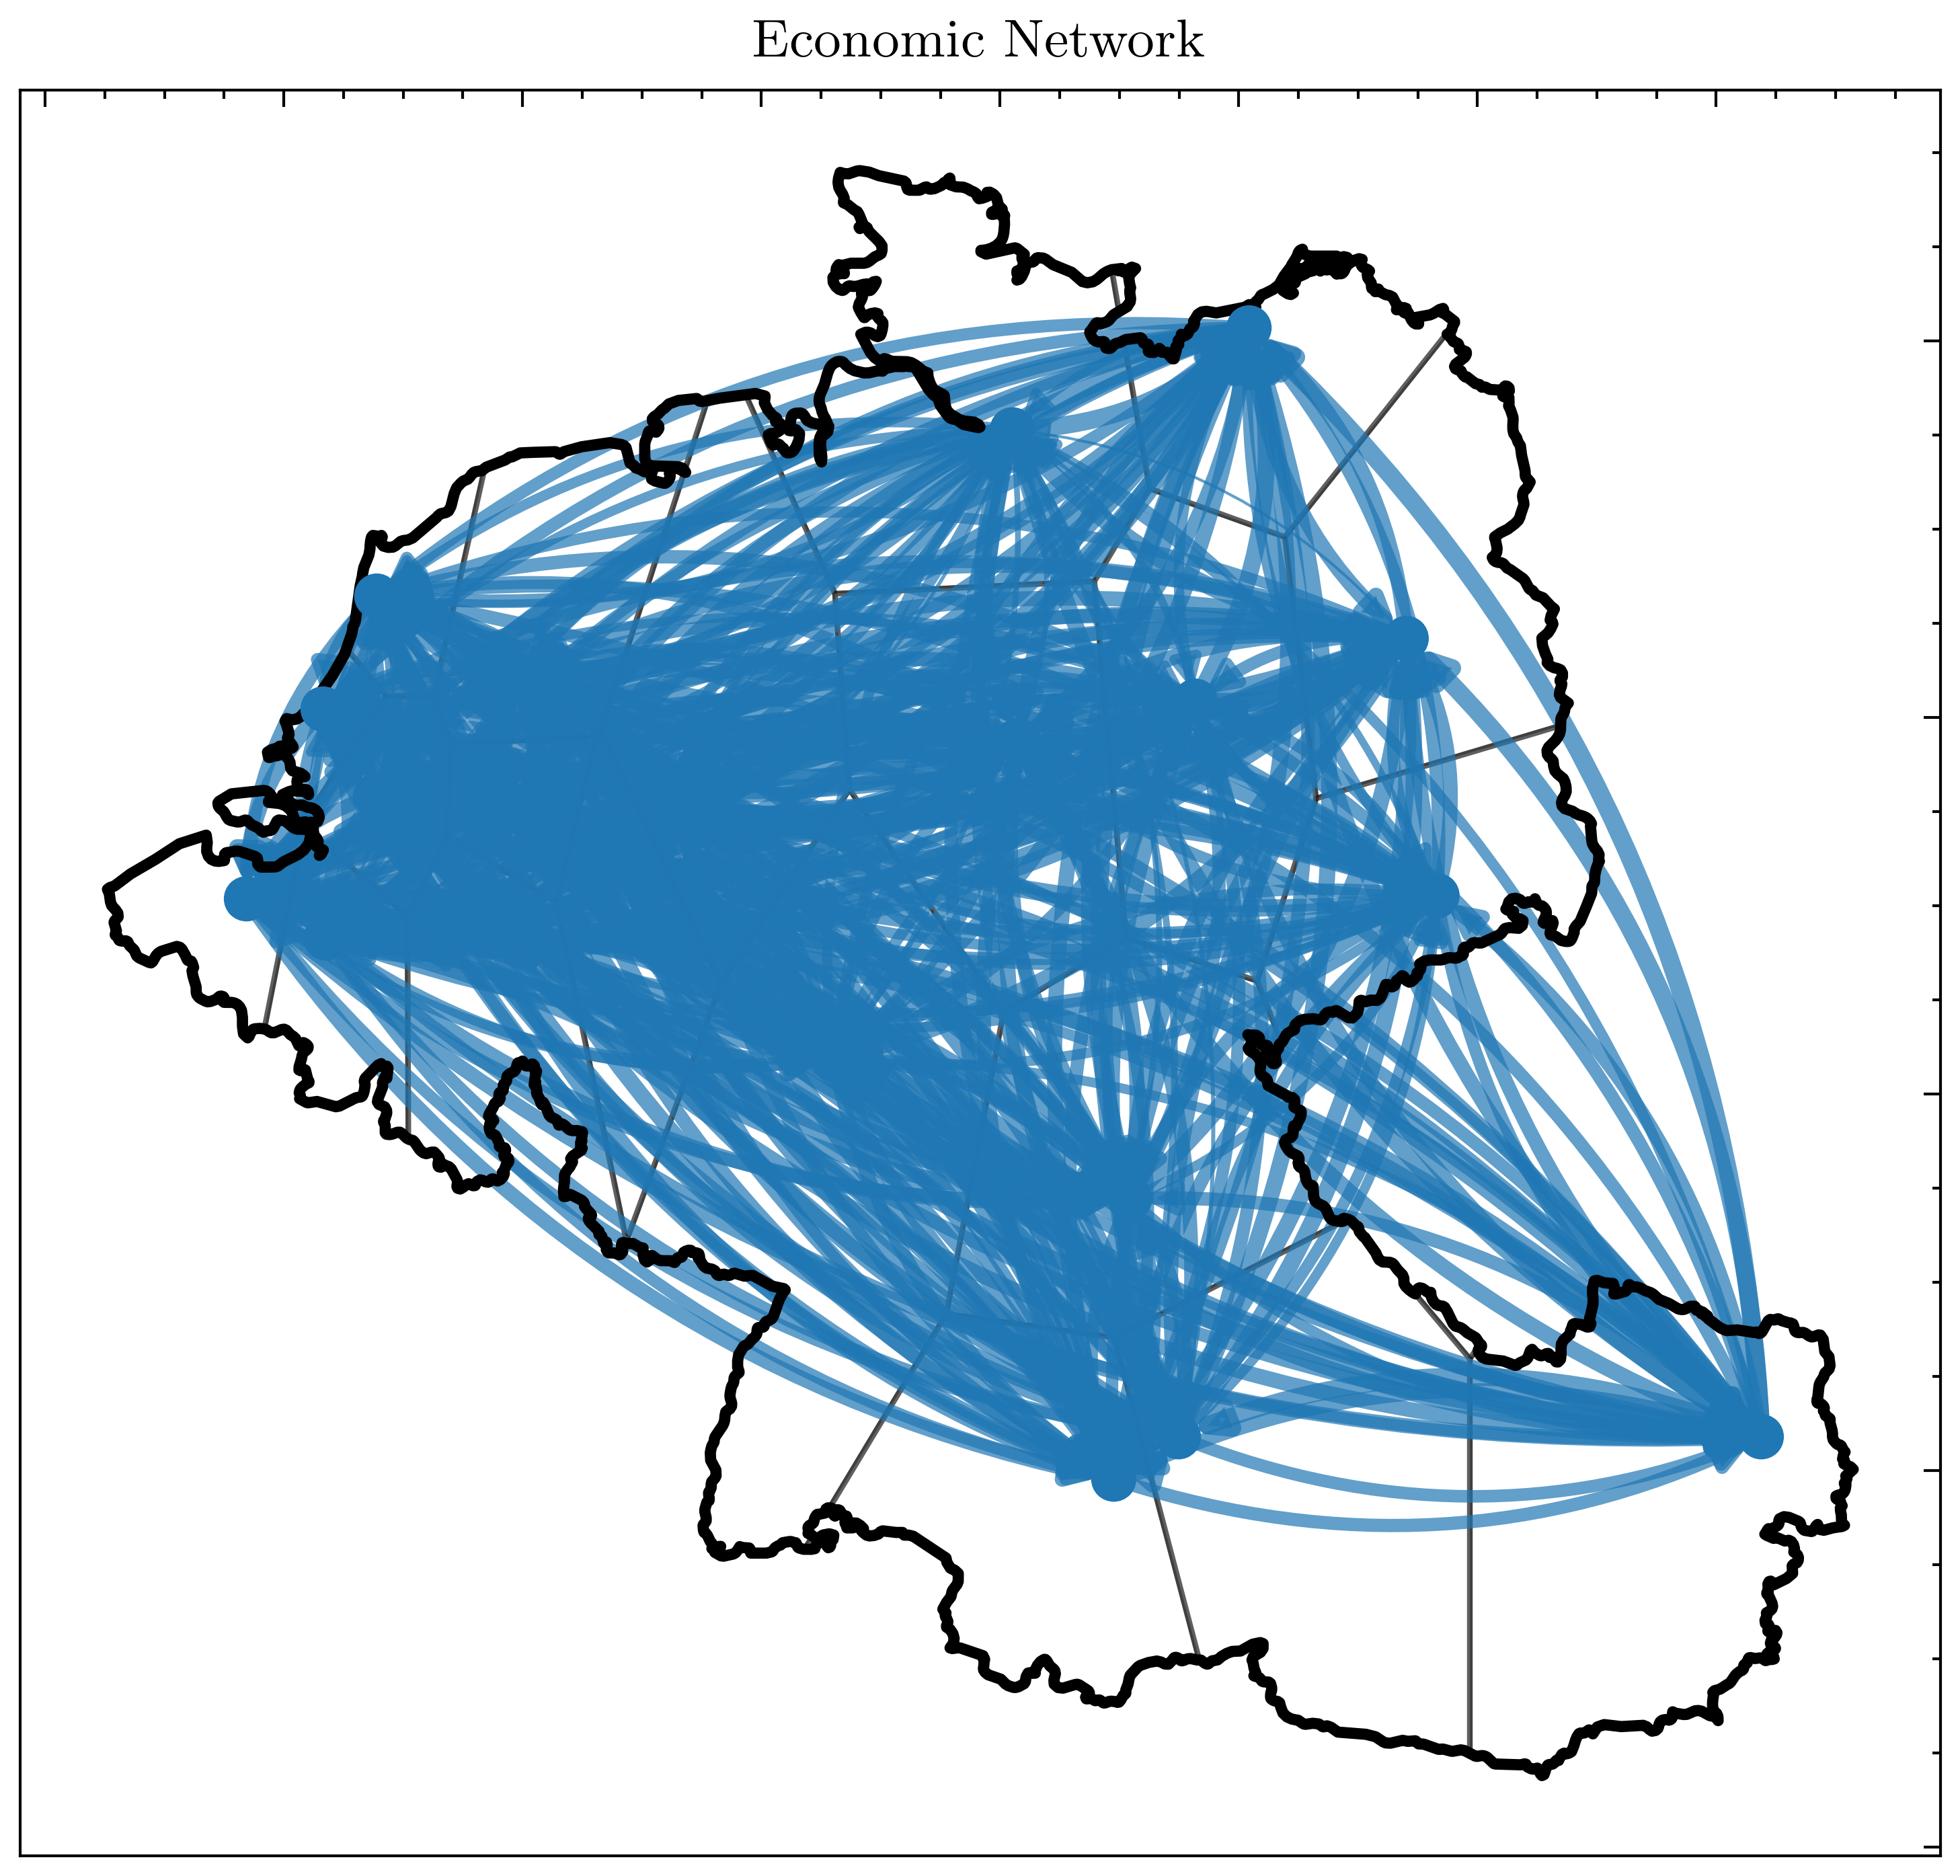

In [15]:
import numpy as np
import networkx as nx
import leidenalg as la
import igraph as ig
import importlib
importlib.reload(infce)


def partition_network(adj_matrix, directed=False):
    """
    Partitions a network into clusters using the Louvain method.

    Parameters:
    - adj_matrix (numpy.ndarray): The adjacency matrix of the network.
    - directed (bool): If True, treats the network as directed. Otherwise, treats it as undirected.

    Returns:
    - dict: A dictionary where keys are node indices and values are cluster indices.
    """
    # Create an igraph graph from the adjacency matrix
    if directed:
        g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_DIRECTED)
    else:
        g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)
    
    # Use the Leiden method for community detection
    partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=0.01)

    # Convert partition to a dictionary
    partition_dict = {i: membership for i, membership in enumerate(partition.membership)}

    return partition_dict



#show lenth of voronoi_gdf
print(len(voronoi_gdf))
#cluster adjacency matrix te_matrix
G = nx.from_numpy_array(te_matrix)
print(len(G))
#compute centrality for each node
centrality = nx.eigenvector_centrality(G)
#partition the network into clusters
partition = partition_network(te_matrix, directed=True)
#print number of partitions
print(len(set(partition.values())))
print(partition)
print(centrality)

#begin figure
fig, ax = plt.subplots(figsize=(5, 5))
# Visualize the network with the partition
infce.visualize_voronoi_with_analysis(voronoi_gdf, boundary, centroid_gdf, te_matrix, partition, centrality, percentile=0, title='Economic Network', figsiz=(10,10), ax=ax)

# Display the figure
plt.show()






In [14]:
def assign_attributes_to_geojson(array, attribute_names, geojson_data):
    # Check if the number of attributes matches the number of features in the GeoJSON
    if len(array) != len(geojson_data['features']):
        raise ValueError("The number of attributes does not match the number of points in the GeoJSON file.")
    
    # Create a DataFrame from the array and attribute names
    df = pd.DataFrame(array, columns=attribute_names)
    
    # Assign attributes to each feature in the GeoJSON file
    for i, feature in enumerate(geojson_data['features']):
        for attr_name in attribute_names:
            feature['properties'][attr_name] = df.iloc[i][attr_name]
    
    return geojson_data

# necessary steps for saving centroid data

- functions to compute network properties
    - make them paralellizable
- callable function to save properties to centroid geojson
- aggregating centroid data files to one file 

In [60]:
#load tesselation_points_1.geojson
geojson_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson'
geojson_data = json.load(open(geojson_path))
#use assign_attributes_to_geojson to assign the partition and centrality values to the geojson_data
new_geojson_data = assign_attributes_to_geojson(array=np.array(list(partition.values())), attribute_names=['partition'], geojson_data=geojson_data)
new_geojson_data = assign_attributes_to_geojson(array=np.array(list(centrality.values())), attribute_names=['centrality'], geojson_data=new_geojson_data)
#save new data file using .tofile
#new_geojson_data.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_points.geojson', driver='GeoJSON')
# Convert the modified GeoJSON data to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Save the modified GeoJSON file
gdf.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/attributed_points.geojson', driver='GeoJSON')



/opt/homebrew/lib/python3.11/site-packages/pyogrio/raw.py:505: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(


- shape file for africa 
- pipline for centroid values 
- 500 nodes as upper limit 
- give config file parameters 



In [ ]:
# def create_dataframe_from_voronoi(voronoi_gdf_path):

#     dataframe = infce.geojson_to_timeseries(geojson_path)

#     #compute percentage change for each process
#     dataframe = dataframe.pct_change()
#     #drop the first row
#     dataframe = dataframe.iloc[1:]
#     #reshape to np arraw with columns as entries
#     data_array = dataframe.to_numpy().T

#     return data_array

# def compute_TE_significance(data_array,):
#     #sturges rule for binning
#     num_bins = int(1 + np.log2(data_array.shape[1]))
#     #estimate perm needed for desired lowest p-value
#     num_perm = int(1/0.05)-1
#     #compute transfer entropy matrix
#     settings = {
#         'discretise_method': 'max_ent', # Discretise continuous data into equal-sized bins
#         'n_discrete_bins': num_bins,  # Number of discrete bins/levels
#         'alph1': 3,
#         'alph2': 3,
#         'alphc': 3
#     }
#     te_matrix, p_value_matrix = infce.compute_TE(data_array,settings=settings , num_permutations=num_perm)
    
#     return te_matrix, p_value_matrix

# def correct_TE_matrix(te_matrix, p_value_matrix):
#     "Correct for relevant subset of Te matrix by correcting for significance and tie strength"
#     te_matrix[p_value_matrix > 0.051] = 0
#     matrix_values = te_matrix.flatten()
#     matrix_nozero = matrix_values[matrix_values != 0]
#     #only consider values above 1 std from mean and enough entries exist
#     if len(matrix_nozero) > 0.01*len(matrix_values):
#         te_matrix[te_matrix < np.mean(matrix_values) + np.std(matrix_values) ] = 0
    
#     return te_matrix

# def partition_network(adj_matrix, directed=False):
#     """
#     Partitions a network into clusters using the Louvain method.

#     Parameters:
#     - adj_matrix (numpy.ndarray): The adjacency matrix of the network.
#     - directed (bool): If True, treats the network as directed. Otherwise, treats it as undirected.

#     Returns:
#     - dict: A dictionary where keys are node indices and values are cluster indices.
#     """
#     # Create an igraph graph from the adjacency matrix
#     if directed:
#         g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_DIRECTED)
#     else:
#         g = ig.Graph.Weighted_Adjacency(adj_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)
    
#     # Use the Leiden method for community detection
#     partition = la.find_partition(g, la.CPMVertexPartition, resolution_parameter=0.01)

#     # Convert partition to a dictionary
#     partition_dict = {i: membership for i, membership in enumerate(partition.membership)}

#     return partition_dict

# def measure_attributes_of_graph(te_matrix):
#     G = nx.from_numpy_array(te_matrix)
    
#     # Compute centrality for each node
#     centrality = nx.eigenvector_centrality(G)
#     partition = partition_network(te_matrix, directed=True)
    
#     # Compute additional metrics
#     degree_centrality = nx.degree_centrality(G)
#     betweenness_centrality = nx.betweenness_centrality(G)
#     closeness_centrality = nx.closeness_centrality(G)
#     pagerank = nx.pagerank(G)
#     clustering_coefficient = nx.clustering(G)
    
#     # Compute the number of different partitions a node is connected to
#     partition_neighbors_count = {}
#     for node in G.nodes():
#         neighbor_partitions = {partition[neighbor] for neighbor in G.neighbors(node)}
#         partition_neighbors_count[node] = len(neighbor_partitions)
    
#     # Combine all metrics into a dictionary
#     attributes = {}
#     for node in G.nodes():
#         attributes[node] = {
#             'degree_centrality': degree_centrality[node],
#             'betweenness_centrality': betweenness_centrality[node],
#             'closeness_centrality': closeness_centrality[node],
#             'eigenvector_centrality': centrality[node],
#             'pagerank': pagerank[node],
#             'clustering_coefficient': clustering_coefficient[node],
#             'partition': partition[node],
#             'partition_neighbors_count': partition_neighbors_count[node]
#         }

#     return attributes

In [22]:
import igraph as ig
#reload inference module
importlib.reload(infce)




# call the functions in sequence
geojson_path = '../Data_summary/Tesselations/attributed_voronoi_all_years_1.geojson'

#pass input AND output path 

data_array = infce.create_dataframe_from_voronoi(geojson_path)
te_matrix, p_value_matrix = infce.compute_TE_significance(data_array)
print("success")
te_matrix = infce.correct_TE_matrix(te_matrix, p_value_matrix, save=False)
attributes = infce.measure_attributes_of_graph(te_matrix)

geojson_path = '/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/tessellation_points_1.geojson'
geojson_data = json.load(open(geojson_path))
new_geojson_data = infce.assign_attributes_to_geojson(attributes, geojson_data=geojson_data)
#save new data file using .tofile
# Convert updated GeoJSON to GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(new_geojson_data['features'])

# Save the new GeoDataFrame to a file
gdf.to_file('/Users/mengeshi/Documents/GitHub/eScience/Data_summary/Tesselations/new_attributed_points.geojson', driver='GeoJSON')




#assign attributes to geojson
# for attributes assign to point geojson file 
#use output path to save the file 


#submission scripts





success


/opt/homebrew/lib/python3.11/site-packages/pyogrio/raw.py:505: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  warnings.warn(
